In [2]:
## Estimate Linear Velocity from 3D time-series displacement on Fernandina Volcano

import os
from datetime import datetime as dt
import h5py
import numpy as np
import matplotlib.pyplot as plt

work_dir = os.path.expanduser('~/development/python/a_python_guide_to_geophysics/FernandinaSenDT128')
os.chdir(work_dir)
print('Go to directory:', work_dir)

Go to directory: /Users/yunjunz/development/python/a_python_guide_to_geophysics/FernandinaSenDT128


In [3]:
# read timeseries HDF5 file
ts_file = 'timeseries.h5'
with h5py.File(ts_file, 'r') as f:
    ts_data = f['timeseries'][:]
    date_list = [i.decode('utf8') for i in f['date'][:].tolist()]
num_date, length, width = ts_data.shape

In [4]:
## prepare design matrix
dates = [dt.strptime(i, '%Y%m%d') for i in date_list]
years = np.array([i.year + (i.timetuple().tm_yday - 1)/365.25 for i in dates], dtype=np.float64)
years -= years[0]
A = np.ones((len(years), 2), dtype=np.float32)
A[:, 0] = years

In [5]:
## property checking of design matrix
A_inv1 = np.dot(np.linalg.inv(np.dot(A.T, A)), A.T)
A_inv2 = np.dot(np.linalg.pinv(np.dot(A.T, A)), A.T)
A_inv3 = np.linalg.pinv(A)
np.allclose(A_inv1, A_inv2), np.allclose(A_inv1, A_inv3)

(True, True)

In [6]:
# estimate velocity
A_inv = np.linalg.pinv(A)
vel, off = np.dot(A_inv, ts_data.reshape(num_date, -1))
vel = vel.reshape(length, width)
off = off.reshape(length, width)

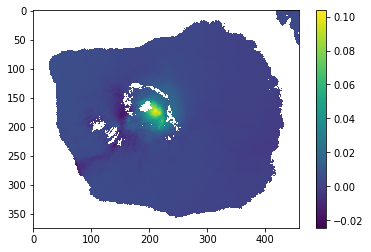

In [7]:
# plot velocity map
mask_file = 'maskTempCoh.h5'
with h5py.File(mask_file, 'r') as f:
    mask = f['mask'][:]
vel[mask == 0] = np.nan
plt.figure()
plt.imshow(vel)
plt.colorbar()
plt.show()

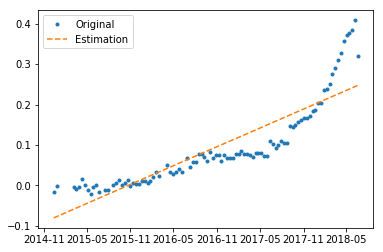

In [11]:
# plot point of interest
y, x = 175, 210
dis_ori = ts_data[:, y, x]
dis_est = vel[y, x] * years + off[y, x]
plt.figure()
plt.plot(dates, dis_ori, '.', label='Original')
plt.plot(dates, dis_est, '--', label='Estimation')
plt.legend()
plt.show()